In [1]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


In [5]:
@tool
def recommend_recipe(dish):
    """주어진 요리에 대한 간단한 레시피를 제공합니다."""
    recipes = {
        "파스타" : "재료: 스파게티 면, 토마토 소스, 올리브 오일, 마늘, 면을 삶고 소스를 부어주세요",
        "불고기": "재료: 소고기, 간장, 설탕, 마늘. 고기를 양념에 재워 볶아주세요.",
        "샐러드": "재료: 양상추, 토마토, 오이, 드레싱. 채소를 썰어 드레싱과 버무려주세요."
    }
    return recipes.get(dish, '죄송하지만 해당 요리의 레시피를 찾을 수 없습니다.')

In [6]:
tools = [recommend_recipe]
tool_node = ToolNode(tools)


model = ChatOpenAI(model = 'gpt-4o-mini', temperature=0).bind_tools(tools)

In [7]:
def should_continue(state: MessagesState):
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'tools'
    return END

In [8]:
def call_model(state: MessagesState):
    message = state['messages']
    response = model.invoke(message)
    return {'messages' : [response]}

In [11]:
workflow = StateGraph(MessagesState)
workflow.add_node('agent', call_model)
workflow.add_node('tools', tool_node)
workflow.set_entry_point('agent')
workflow.add_conditional_edges('agent', should_continue)

checkpointer = MemorySaver()

In [12]:
app = workflow.compile(checkpointer=checkpointer)


final_state = app.invoke(
    {'messages' : [HumanMessage(content="불고기 레시피 알려줘")]},
    config={'configurable' : {'thread_id' : 100}}
)


In [13]:
final_state['messages'][-1].content


'재료: 소고기, 간장, 설탕, 마늘. 고기를 양념에 재워 볶아주세요.'

In [14]:
from IPython.display import Image, display


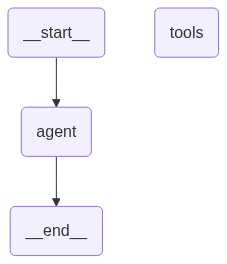

In [16]:
display(Image(app.get_graph().draw_mermaid_png()))

# sudo apt-get install graphviz libgraphviz-dev pkg-config



Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


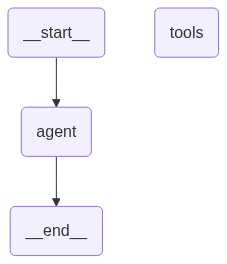

In [17]:
workflow.add_edge("tools", 'agent')

checkpointer = MemorySaver()
app = workflow.compile(checkpointer=checkpointer)


final_state = app.invoke(
    {'messages' : [HumanMessage(content="불고기 레시피 알려줘")]},
    config={'configurable' : {'thread_id' : 100}}
)


final_state['messages'][-1].content


from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


## agentic RAG 로 지능형 정보 검색 시스템 만들기

- 사용자의 질문 입력 - > 에이전트는 적절한 도구를 사용하여 정보를 검색
- 이를 기반으로 답변을 생성
- 에이전트는 검색 결과의 관련성을 평가 한 이후, 경우에 따라 질문을 재작성하여 더 정확한 정보 제공

In [18]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [20]:
urls = [
    "https://finance.naver.com/",
    "https://finance.yahoo.com/",
    "https://finance.daum.net/",
]


docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [21]:
docs_list2 = []
for sublist in docs:
    for item in sublist:
        docs_list2.append(item)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)


In [22]:
doc_splits = text_splitter.split_documents(docs_list)


vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

retriever = vectorstore.as_retriever()


## agent 상태 정의 

In [24]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], add_messages]

## 검색도구 생성 


In [25]:
from langchain.tools.retriever import create_retriever_tool


retriever_tool = create_retriever_tool(
    retriever,
    'retrieve_blog_posts',
    '네이버, 야후, 다음의 금융 관련 정보를 검색하고 반환합니다.'
)


## 그래프 작성 


In [26]:
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition


/home/sunsnu/miniconda3/envs/openai/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
#Edges


#Edges


def grade_documents(state):
    """
    검색된 문서가 질문과 관련이 있는지 평가합니다.


    Args:
        state : 현재 상태
    Returns :
        str: 문서의 관련성에 따라 다음 노드 결정 ("generate" or "rewrite")
    """
    print("----문서 관련성 평가----")


    class grade(BaseModel):
        """관련성 평가를 위한 이진 점수"""
        binary_score: str = Field(description="관련성 점수 'yes' 또는 'no")


    model = ChatOpenAI(model='gpt-4o-mini', temperature=0, streaming=True)


    llm_with_tool = model.with_structured_output(grade)


    prompt = PromptTemplate(
        template="""당신은 사용자 질문에 대해서 검색된 문서의 관련성을 평가하는 평가자입니다.
        여기 검색된 문서가 있습니다:
        {context}
        여기 사용자 질문이 있습니다:
        {question}
        문서가 사용자 질문과 관련된 키워드 또는 의미를 포함하면 관련성이 있다고 평가하세요.
        문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 이진 점수를 주세요
        """
    )


    chain = prompt | llm_with_tool

    messages = state['messages']
    last_message = messages[-1]


    question = messages[0].content
    docs = last_message.content


    scored_result = chain.invoke({'question': question, 'context' : docs})


    score = scored_result.binary_score


    if score == "yes":
        print("--결정: 문서 관련성 있음--")
        return "generate"
    else:
        print("--결정: 문서 관련성 없음")
        return 'rewrite'
   


In [29]:
tools = [retriever_tool]
def agent(state):
    """
    현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다.
    주어진 질문에 따라 검색 도구를 사용하여 검색을 수행하거나 단순히 종료하기로 결정합니다.


    Arggs:
        state: 현재 상태
    Returns:
        dict: 메시지에 에이전트 응답이 추가된 업데이트된 상태
    """
    messages = state['messages']
    print("에이전트로 전달된 메시지들: ", messages)
    model = ChatOpenAI(model='gpt-4o-mini', temperature=0, streaming=True)
   
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    state['messages'].append(response)
    return state
   




def rewrite(state):
    """
    질문을 재작성(변형)하여 더 나은 질문을 생성합니다.


    Args:
        state (messages): 현재 상태


    Returns:
        dict: 재구성된 질문으로 업데이트된 상태
    """


    print("---질문 변형---")
    messages = state["messages"]
    question = messages[0].content


    msg = [
        HumanMessage(
            content=f"""다음 입력을 보고 근본적인 의도나 의미를 파악해보세요.\n
            초기 질문은 다음과 같습니다:
            \n-------\n
            {question}
            \n-------\n
            개선된 질문을 만들어주세요:""",
        )
    ]
    # 평가자
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = model.invoke(msg)


    # 반환되는 메세지가 올바른지 확인
    print("Rewrite 단계에서의 응답:", response)


    # 상태 업데이트 - 기존 메시지에 새 메시지를 추가하여 상태를 업데이트
    state["messages"].append(response)
   
    return state


In [30]:
def generate(state):
    """
    답변 생성


    Args:
        state (messages): 현재 상태


    Returns:
         dict: 재구성된 질문으로 업데이트된 상태
    """
    print("---생성---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]


    question = messages[0].content
    docs = last_message.content


    # 프롬프트
    # prompt = hub.pull("rlm/rag-prompt")
    # 프롬프트 정의
    prompt = PromptTemplate(
    template="""당신은 질문-답변 작업을 위한 어시스턴트입니다.
    아래 제공된 문맥을 사용하여 질문에 답변해주세요.
    답을 모를 경우 '모르겠습니다'라고 말해주세요. 답변은 최대 3문장으로 간결하게 작성하세요.
   
    질문: {question}
    문맥: {context}
    답변: """,
    input_variables=["context", "question"],
    )


    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)
   


    # 체인
    rag_chain = prompt | llm | StrOutputParser()


    # 실행
    response = rag_chain.invoke({"context": docs, "question": question})
   
    return {"messages": [response]}

In [31]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [35]:
#그래프 정의 
workflow.add_node("agent", agent)  # 에이전트 노드
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # 검색 도구 노드
workflow.add_node("rewrite", rewrite)  # 질문 재작성 노드
workflow.add_node(
    "generate", generate
)  # 문서가 관련성이 있다고 판단된 후 응답 생성 노드
# 에이전트 노드를 호출하여 검색을 결정합니다.
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    tools_condition,
    {
        # 조건 출력을 그래프 내 노드로 변환, 반환 값: 실행 노드
        "tools": "retrieve",
        END: "generate",
    },
)
# 검색 후 문서 관련성 평가
workflow.add_conditional_edges(
    "retrieve",
    # 에이전트 결정 평가
    grade_documents,
    {
        # 조건 출력을 그래프 내 노드로 변환, 반환 값: 실행 노드
        "generate" : "generate",
        "rewrite" : "rewrite"
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")
graph = workflow.compile()


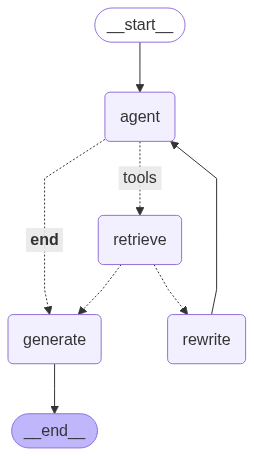

In [36]:
graph

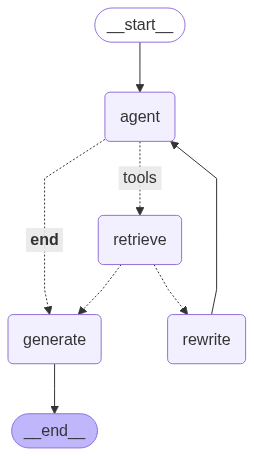

에이전트로 전달된 메시지들:  [HumanMessage(content='삼성전자 주가는?', additional_kwargs={}, response_metadata={}, id='c4590d9b-de38-48b4-b296-234f731dd8bc')]
"노드 'agent'의 출력 결과:"
'---'
{ 'messages': [ HumanMessage(content='삼성전자 주가는?', additional_kwargs={}, response_metadata={}, id='c4590d9b-de38-48b4-b296-234f731dd8bc'),
                AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_6ZD3b8XwtF4qYCM6ByGQWAQc', 'function': {'arguments': '{"query":"삼성전자 주가"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'}, id='run--54b7ac4f-dcea-48af-9eab-33a7bb17c430-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': '삼성전자 주가'}, 'id': 'call_6ZD3b8XwtF4qYCM6ByGQWAQc', 'type': 'tool_call'}])]}
'\n---\n'
----문서 관련성 평가----


/home/sunsnu/miniconda3/envs/openai/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


--결정: 문서 관련성 있음--
"노드 'retrieve'의 출력 결과:"
'---'
{ 'messages': [ ToolMessage(content='-1.18%\n\t\t\t\t\n\n\n\n삼성전자우\n57,500\n상승 800\n\n\n\t\t\t\t+1.41%\n\t\t\t\t\n\n\n\nKB금융\n114,300\n하락 1,300\n\n+11.27%\n\t\t\t\t\n\n\n\n삼성전자\n70,300\n상승 1,500\n\n\n\t\t\t\t+2.18%\n\t\t\t\t\n\n\n\n두산에너빌리티\n65,400\n하락 900\n\n삼성전자\n70,300\n상승 1,500\n\n\n\t\t\t\t+2.18%\n\t\t\t\t\n\n\n\nSK하이닉스\n260,750\n상승 2,250\n\n\n\t\t\t\t+0.87%\n\n삼성전자\n70,300\n상승 1,500\n\n\n\t\t\t\t+2.18%\n\t\t\t\t\n\n\n\nSK하이닉스\n260,500\n상승 2,000\n\n\n\t\t\t\t+0.77%', name='retrieve_blog_posts', id='c063872b-8970-4be5-bc13-1b9e34aa226c', tool_call_id='call_6ZD3b8XwtF4qYCM6ByGQWAQc')]}
'\n---\n'
---생성---
"노드 'generate'의 출력 결과:"
'---'
{'messages': ['삼성전자 주가는 70,300원이며 상승폭은 1,500원으로 +2.18% 상승했습니다.']}
'\n---\n'


In [38]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))






import pprint
inputs = {
    'messages': [('user', '삼성전자 주가는?') ]}


for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"노드 '{key}'의 출력 결과:")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")